In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve

## SIRD model in Python 

In [2]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((gamma+rho)*I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [3]:
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [4]:
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label='Deceased')


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    # ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D
    

In [5]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph
    

## Bulk 

In [6]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [7]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
            },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            },
        'Sweden' : {
        'data' : pd.read_csv("../processed_data/cumDeathSweden.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 10420000
            },
}


### Testing MCMC model with ODE SIRD

In [8]:
import math
N = 60000000
i0 = 300
s0 = N-i0
beta = 0.03
gamma = 0.04
rho = 0.11
time = 0
k = i0/s0
# Integrate the SIR equations over the time grid, t.
solution = 0
for time in range(1):
    solution += rho*(i0*(1+k)**(beta/(beta-(gamma)))*(1+k*math.e**(beta-(gamma+rho))*time)**-(beta/(beta-(gamma+rho)))*math.e**((beta-(gamma+rho))*(time)))

print(getSIRD(100,60000000,300,0.03,0.04,0.11,[0.01,0.03,0.04])[3][1])
print(solution)

31.39233857398158
32.999505002475004


## First Lockdown

### Goodness of Fit

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']
    df_param = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]
    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(60,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

    deaths = df_real["cumDeath"].tolist()
    deaths = deaths[startDate[0]-10:startDate[0]]

    deaths_predicted = sird[3]
    deaths_predicted = deaths_predicted[0:10]

    r2 = r2_score(deaths, deaths_predicted)
    mse = mean_squared_error(deaths, deaths_predicted)
    rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))
    result = [country,r2,mse,rmse]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Mean Squared Error (MSE)','Root Mean Squared Error (RMSE)'])
df

,Country,R-Squared (R2),Mean Squared Error (MSE),Root Mean Squared Error (RMSE)
0,Switzerland,-1.085166,193.524218,1.937622
1,Netherlands,-0.577620,21.518743,0.389573
2,France,0.063149,1504.854627,1.524207
3,Germany,0.880873,107.448011,0.784971
4,Italy,0.825301,1948.140708,1.096279
5,Spain,0.173945,1187.008678,0.510668
6,UK,0.923900,4430.230849,1.295761


In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']
    df_param = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(30,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

    deaths = df_real["cumDeath"].tolist()
    deaths = deaths[startDate[0]-10:startDate[0]+10]
    
    deaths_predicted = sird[3]
    deaths_predicted = deaths_predicted[0:20]
    
    r2 = r2_score(deaths, deaths_predicted)
    mse = mean_squared_error(deaths, deaths_predicted)
    rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))
    result = [country,r2,mse,rmse]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Mean Squared Error (MSE)','Root Mean Squared Error (RMSE)'])
df

,Country,R-Squared (R2),Mean Squared Error (MSE),Root Mean Squared Error (RMSE)
0,Switzerland,0.844588,753.716998,0.432995
1,Netherlands,0.692693,1944.970623,0.544705
2,France,0.735262,62026.007716,0.780052
3,Germany,0.825636,17075.203896,0.543185
4,Italy,0.842276,125891.256706,0.873804
5,Spain,0.697392,127457.298304,0.864865
6,UK,0.846768,490743.882573,0.966125


### Graph

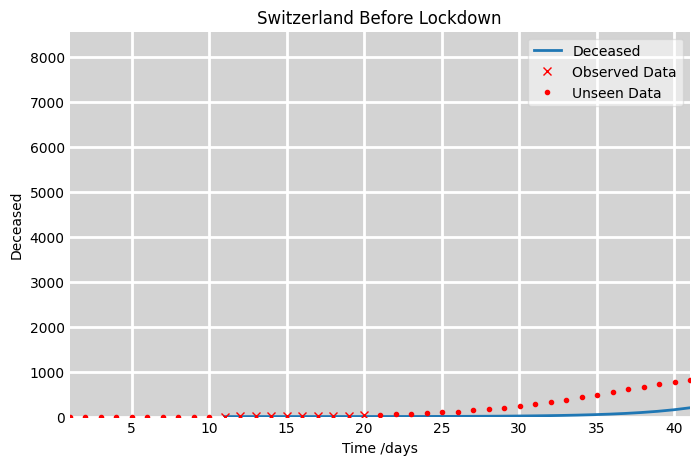

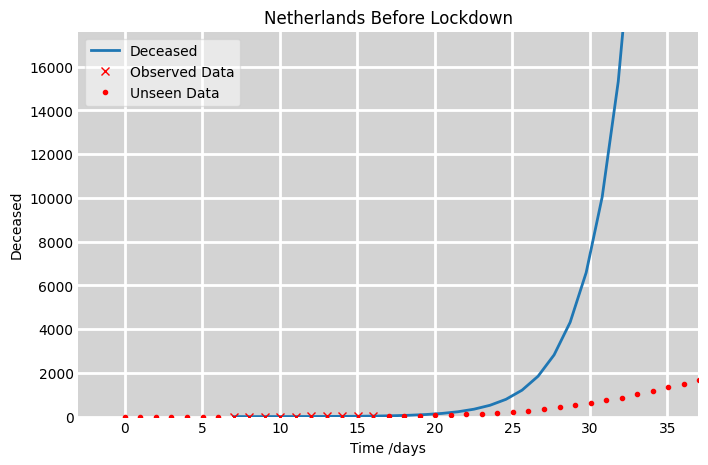

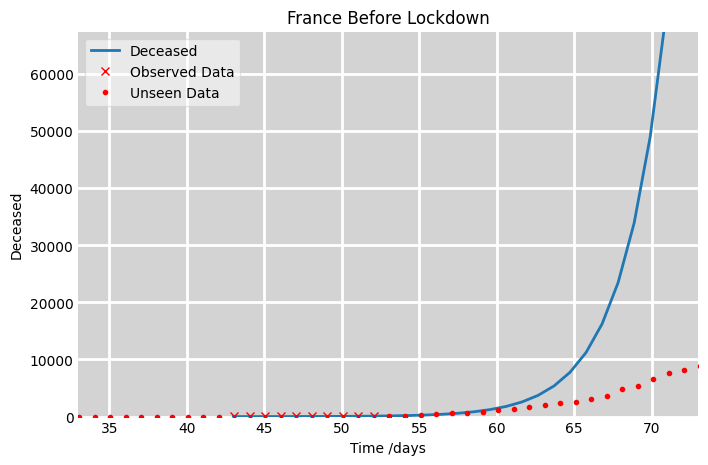

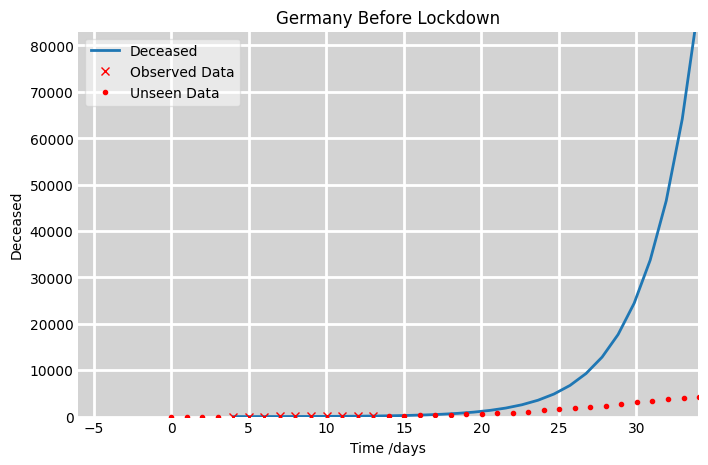

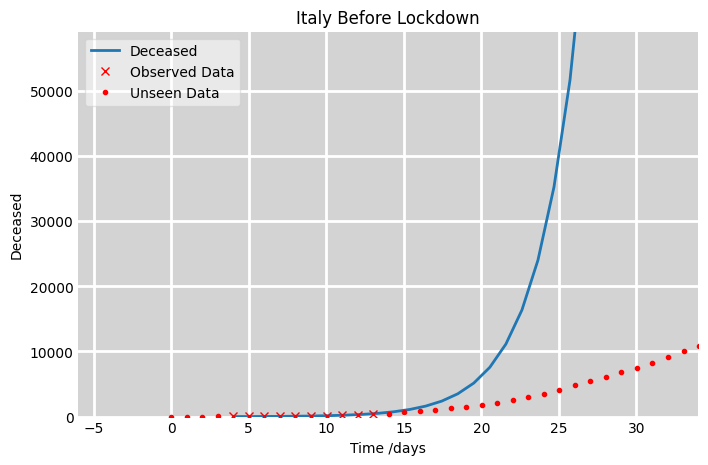

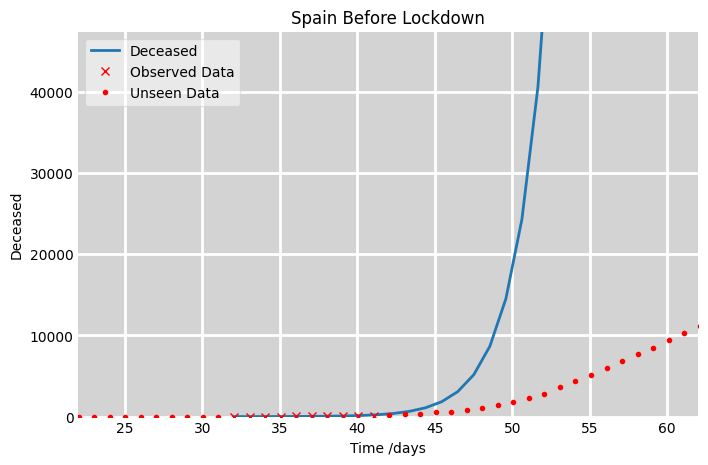

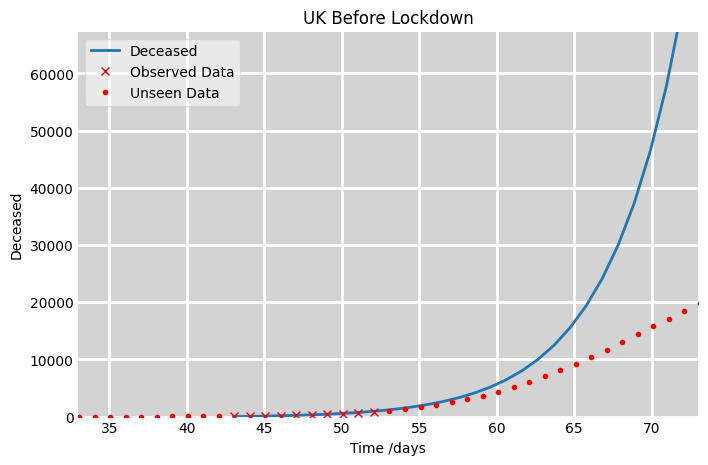

In [20]:
country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,0))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,30, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start-10,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    ax1.set_title(country + " Before Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,0)
    plt.savefig('results/first_q/'+country+'.png')


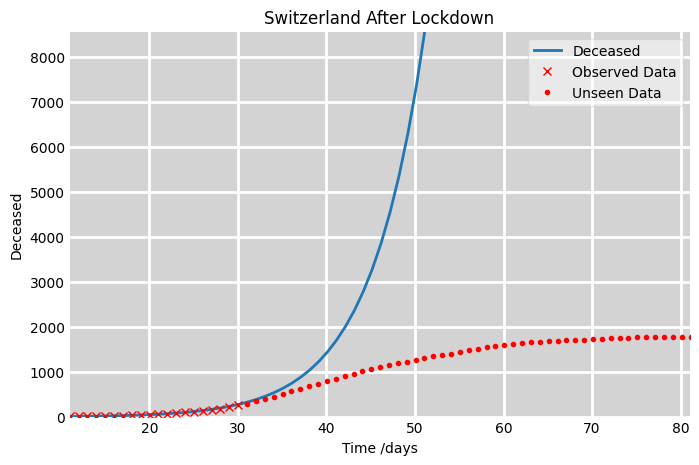

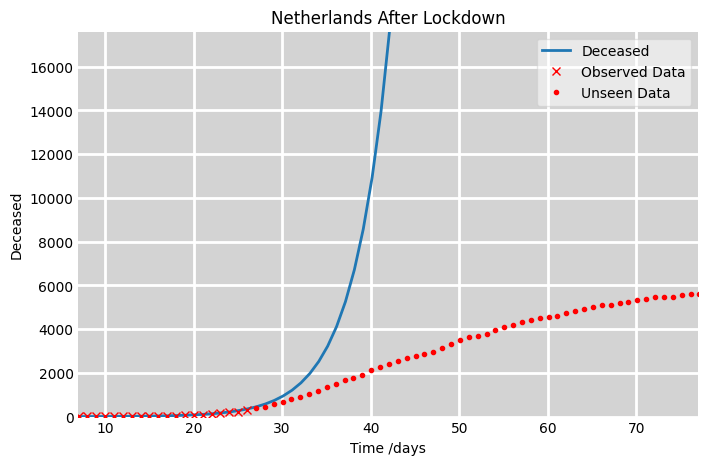

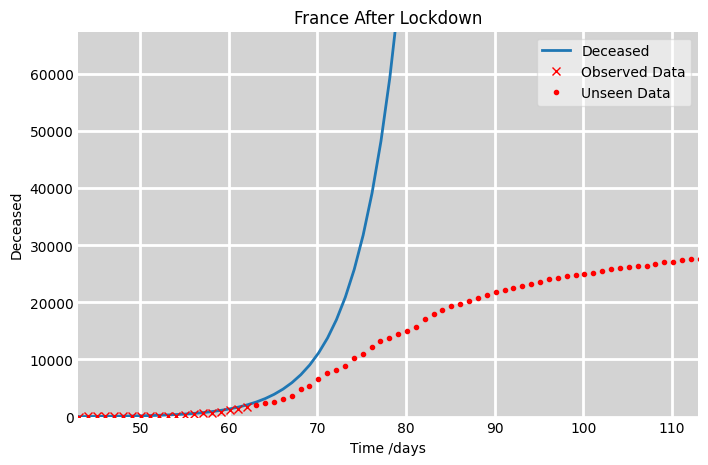

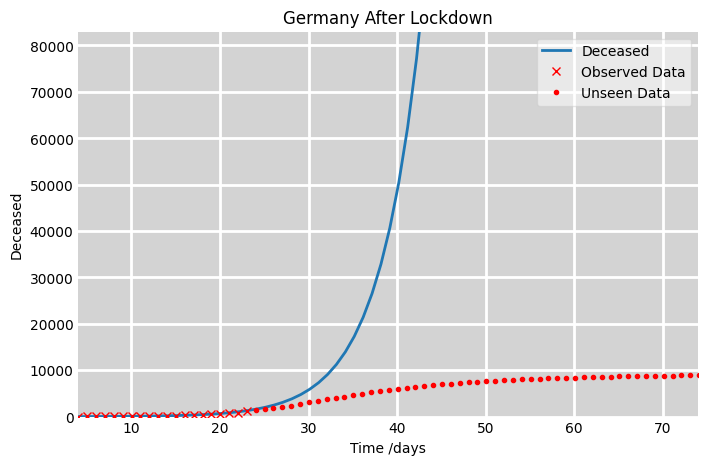

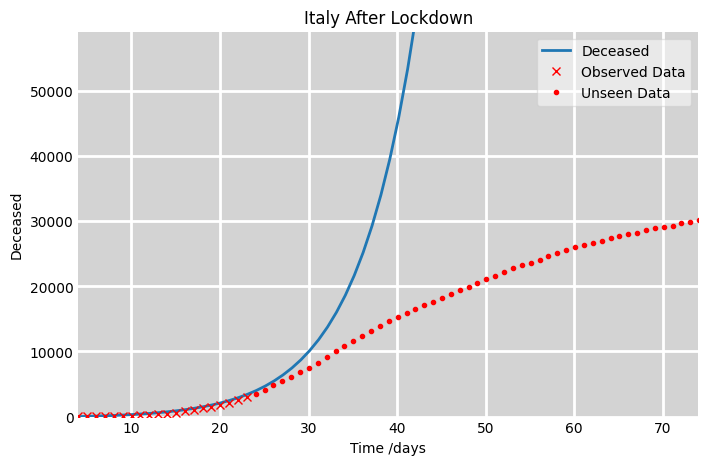

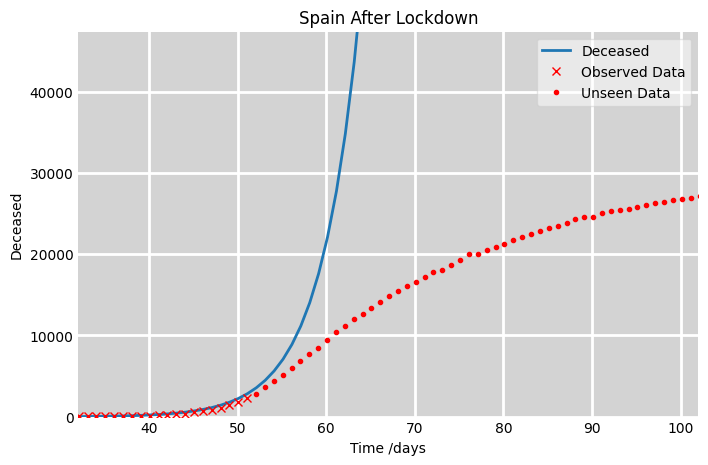

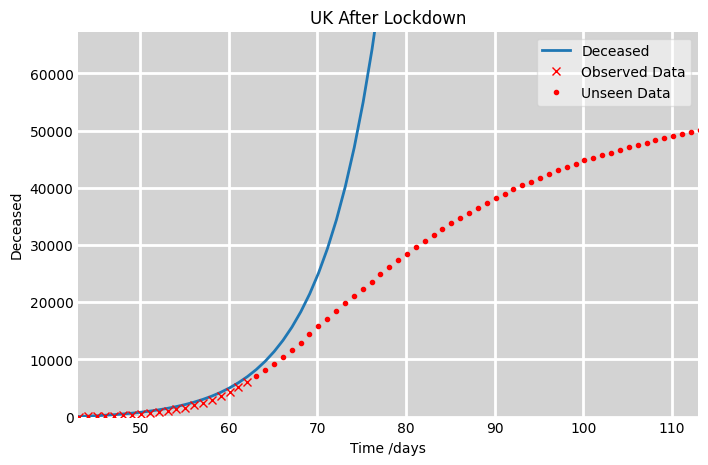

In [14]:
country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,10))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    sird_deaths[country] = {
        'deaths':graph,
        'date': obvData_end+30
    }
    ax1.set_title(country + " After Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,14,True)
    plt.savefig('results/first_q/'+country+'.png')

### Quantifying difference

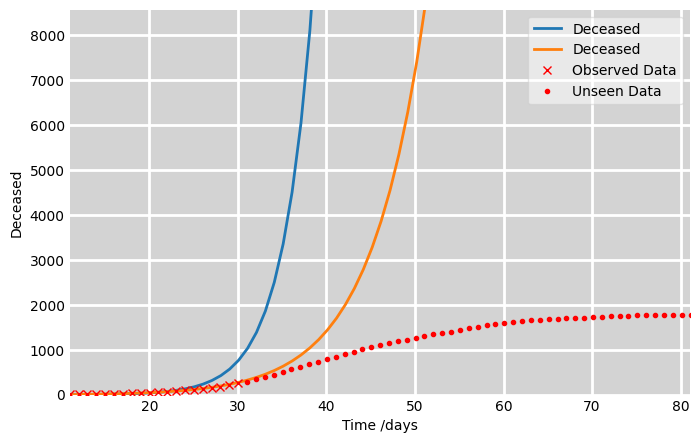

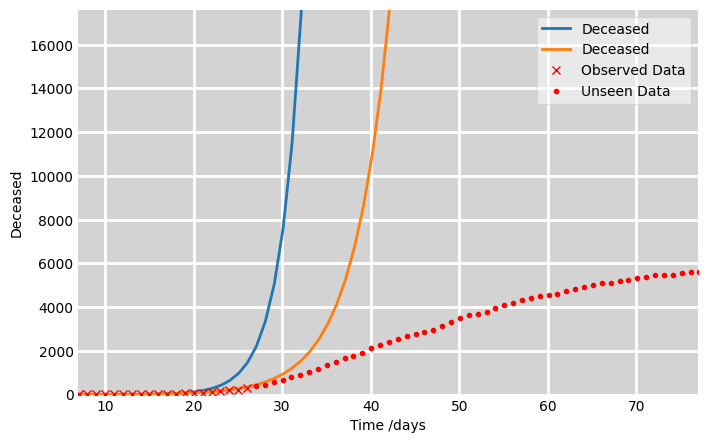

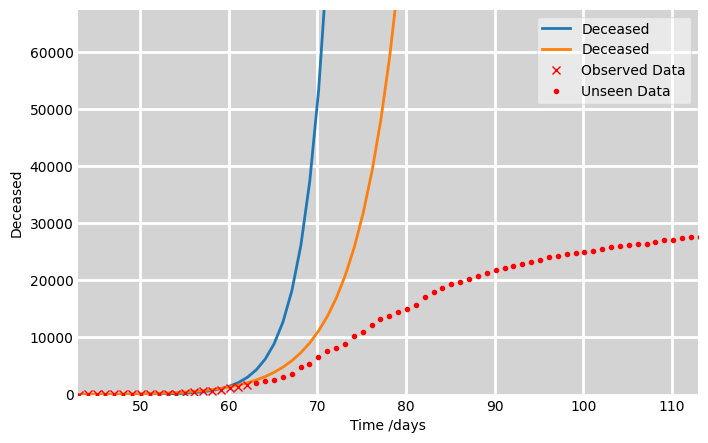

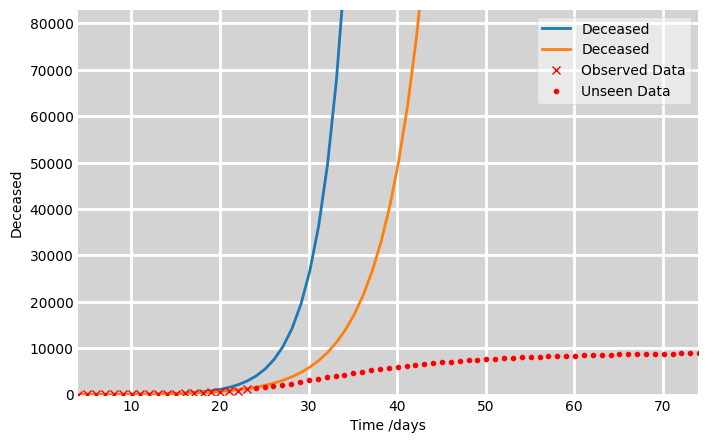

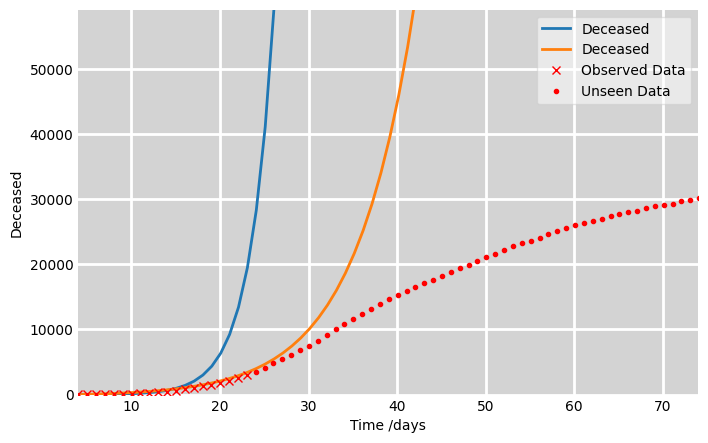

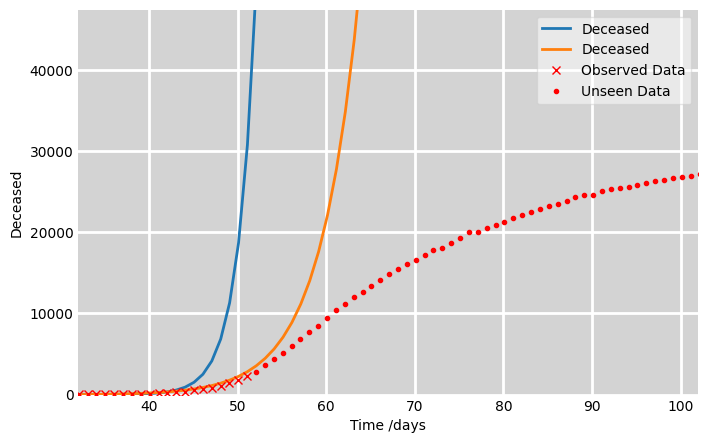

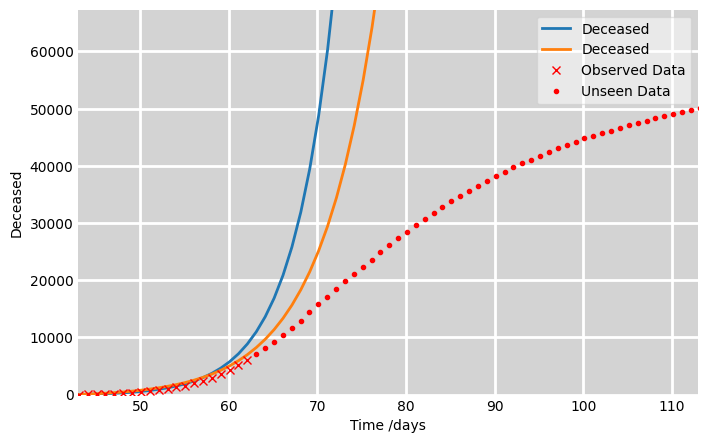

In [17]:
country_names = ['Switzerland', 'Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    offset=0
    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,10))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,14,True)
    plt.savefig('results/first_q/'+country+'.png')

## Second lockdown

/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/216308

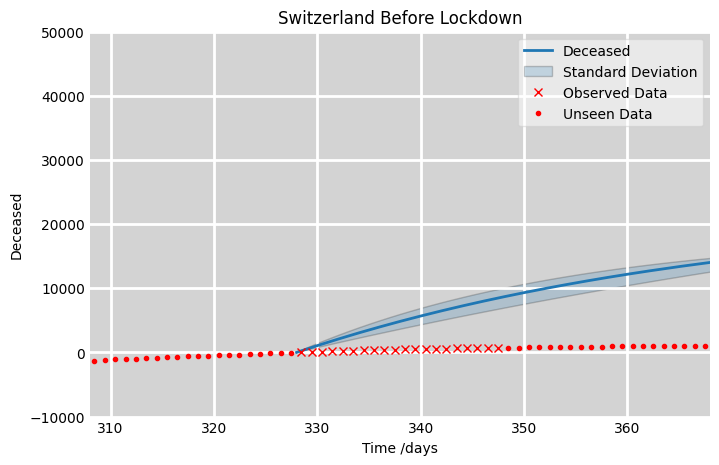

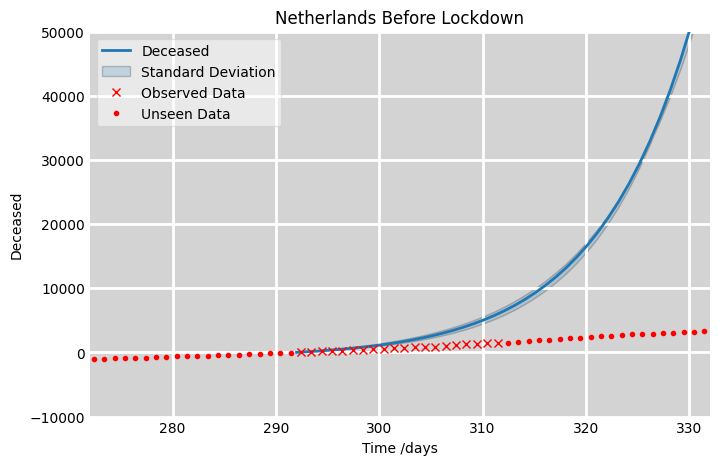

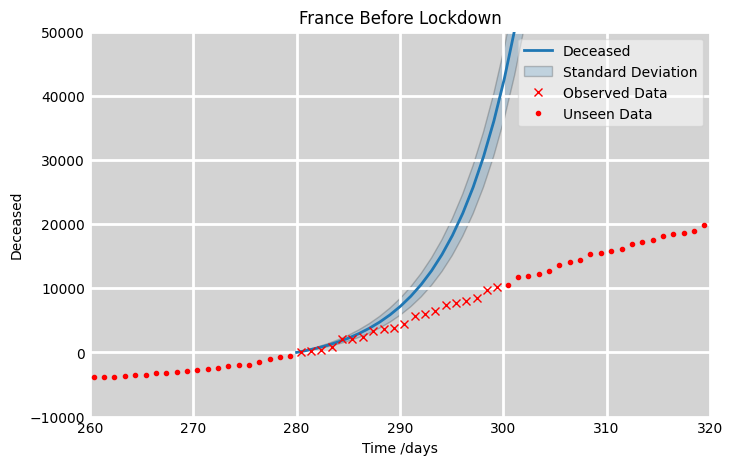

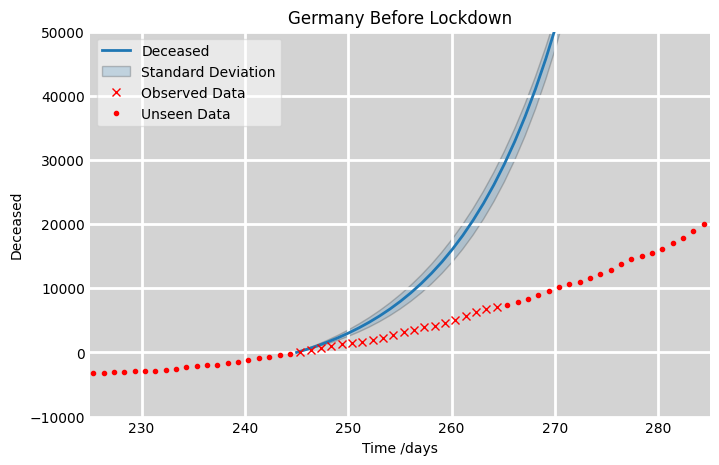

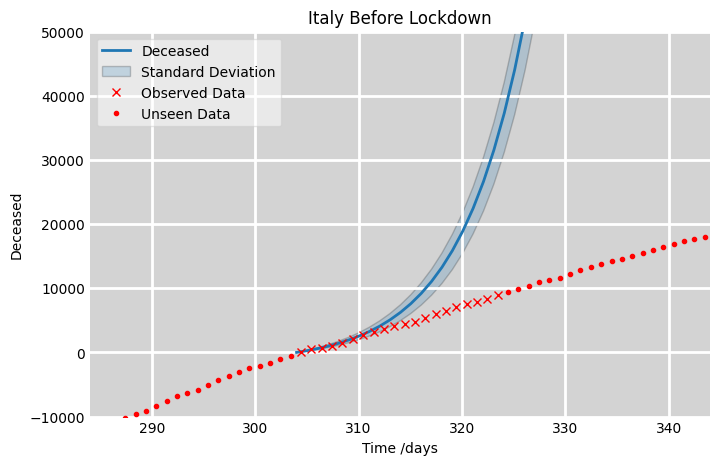

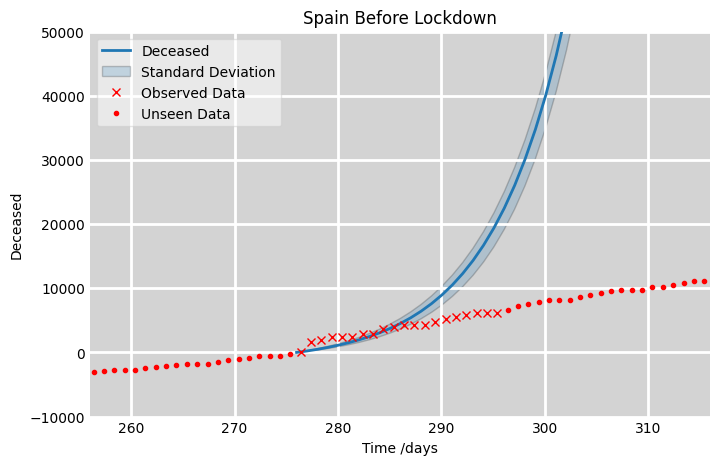

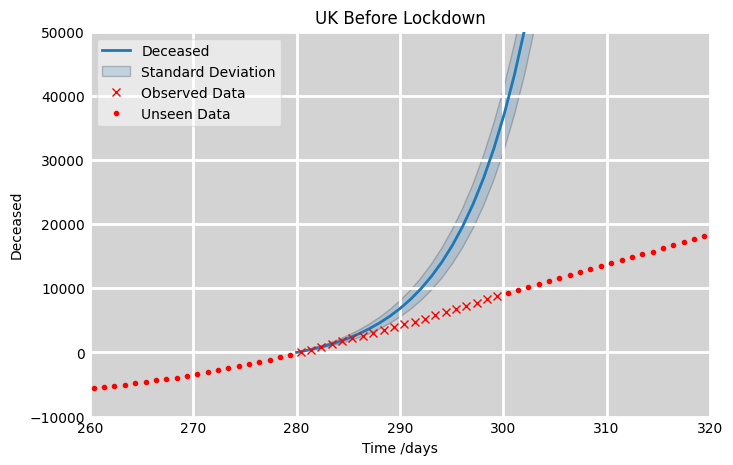

In [95]:
country_names = ['Switzerland','Netherlands','France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['sLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv('mcmc_data/'+country+"/sLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [-10000,50000], [obvData_start-20,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate), False)
    plotRealData(ax1, realData, obvData_start, obvData_end, graph, 0, True)
    ax1.set_title(country + " Before Lockdown")
    plt.savefig('results/second_q/'+country+'.png')


/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_9923/216308

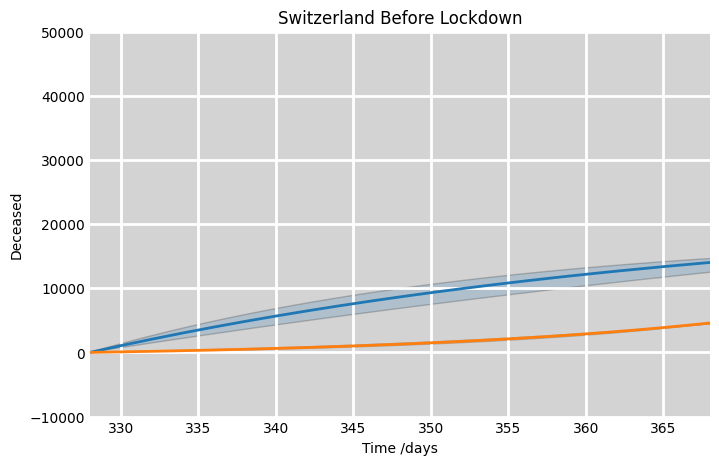

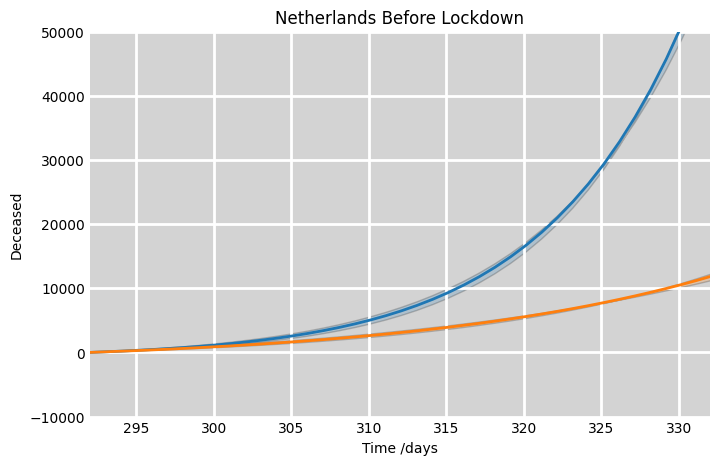

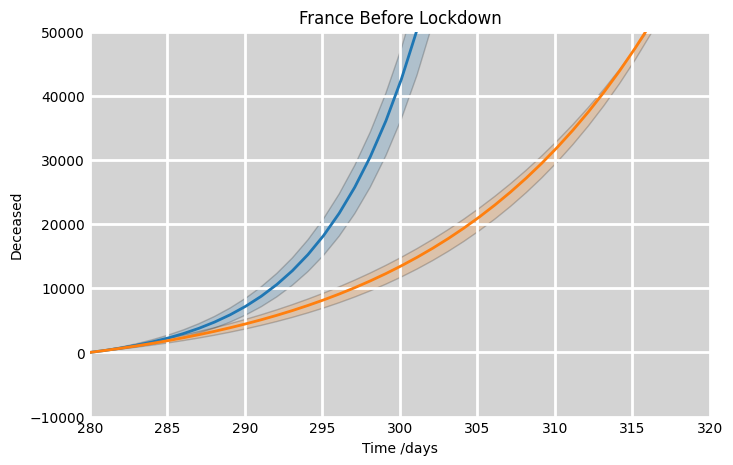

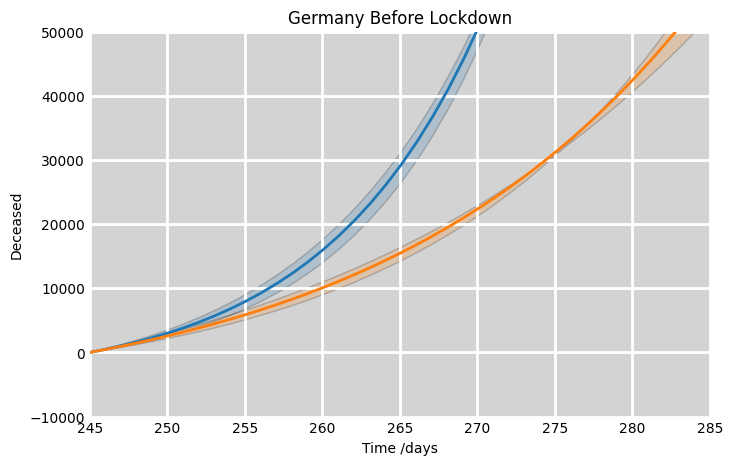

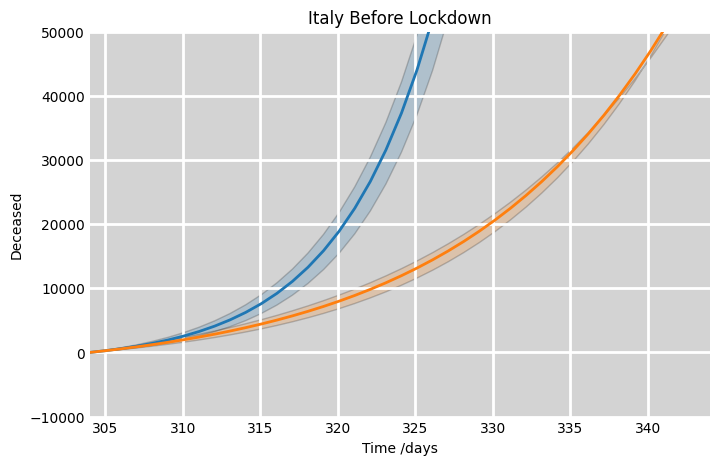

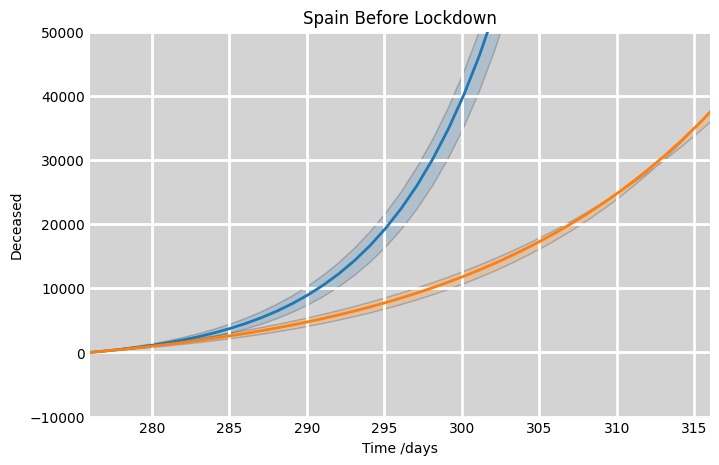

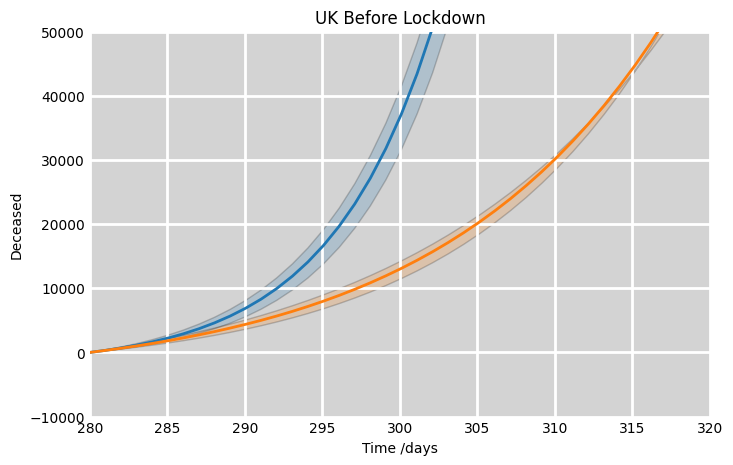

In [96]:
country_names = ['Switzerland','Netherlands','France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['sLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
    df = pd.read_csv('mcmc_data/'+country+"/sLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [-10000,50000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate), False)
    df = pd.read_csv('mcmc_data/'+country+"/sLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [-10000,50000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate), False)
    ax1.set_title(country + " Before Lockdown")
    plt.savefig('results/second_q/'+country+'.png')

/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_2339/2163080474.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


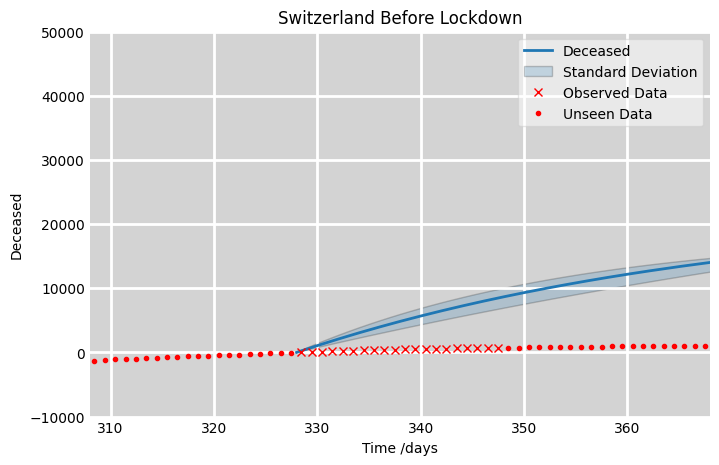

In [45]:
country = "Switzerland"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
# Plot the data on three separate curves for S(t), I(t) and R(t)

pop = dataset[country]['pop']
startDate = dataset[country]['sLock'][0]
realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
firstDate = realData.loc[0]['date']

obvData_start = timeTot(firstDate,startDate)
obvData_end = timeTot(firstDate,addTime(startDate,20))
add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
df = pd.read_csv('mcmc_data/'+country+"/sLock_before.csv")
graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [-10000,50000], [obvData_start-20,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate), False)
plotRealData(ax1, realData, obvData_start, obvData_end, graph, 0, True)
ax1.set_title(country + " Before Lockdown")
plt.savefig('results/second_q/'+country+'.png')
